In [50]:
import numpy as np
import pandas as pd

from sklearn import preprocessing, model_selection
import tensorflow as tf

In [2]:
data = pd.read_csv("pok.csv")
data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(data[["Type 1", "Type 2"]]))
cat = enc.categories_[0]
def enc(arr):
    ret = np.zeros((len(arr),len(cat)))
    for elem in range(len(arr)):
        if pd.isna(arr[elem]):
            continue
        ret[elem][cat.tolist().index(arr[elem])] = 1
    return ret

In [51]:
y=enc(data["Type 1"]) + enc(data["Type 2"])

In [52]:
x = np.array(data.drop(["#", "Name", "Type 1", "Type 2", "Generation", "Legendary", "Total"], 1))
y.shape = (len(y),18)
scaler = preprocessing.MinMaxScaler().fit(x)
x = scaler.transform(x)

/tmp/ipykernel_2560/3164325197.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = np.array(data.drop(["#", "Name", "Type 1", "Type 2", "Generation", "Legendary", "Total"], 1))


In [119]:
#x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.1)

In [13]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, input_shape=(6,), activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(18, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



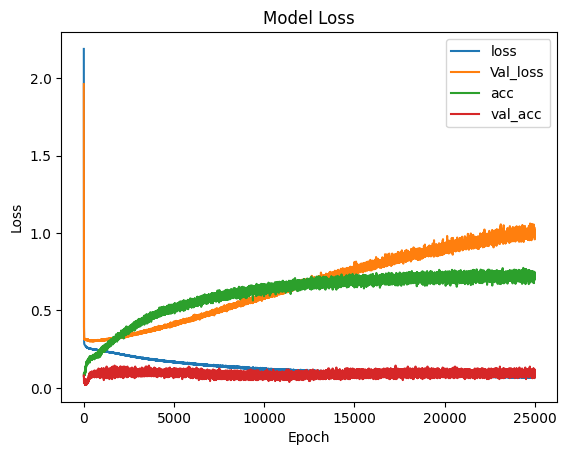

In [14]:
# Train the model
history=model.fit(x, y, epochs=25000, verbose=0, batch_size=64, validation_split=0.2)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'Val_loss', 'acc', 'val_acc'], loc='upper right')
plt.show()

In [53]:
score,acc = model.evaluate(x,y)

25/25 [==============================] - 0s 3ms/step - loss: 0.2577 - accuracy: 0.6112


In [76]:
testing = 34
def getTypes(x):
    x = np.array([x,])
    predicted = model.predict(x)
    mx = sorted(predicted[0])[-2:]
    if mx[1]<0.1:
        mx = [mx[0]]
    types = []
    for i in mx:
        types.append(cat[np.where(predicted[0]==i)][0])
    return types
tp = []
for t in np.where(y[testing]==1)[0]:
    tp.append(cat[t])

print("Real: " + str(tp))
print("Predicted: " + str(getTypes(x[testing])))


Real: ['Poison']
1/1 [==============================] - 0s 53ms/step
Predicted: ['Normal', 'Poison']
